In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import lab4_hmc as hmc

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [3]:
X_train = np.array(df_train.iloc[:, :-1])
y_train = np.array(df_train.iloc[:, -1])
X_test = np.array(df_test.iloc[:, :-1])
y_test = np.array(df_test.iloc[:, -1])

scaler = StandardScaler() # Standardise input variables

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Define Functions Here

In [4]:
def e_func(x, X, t):
    w = x[:8]
    sigma_w_2 = x[8]
    sigma_n_2 = x[9]
    N = X.shape[0]
    M = X.shape[1]
    lgp1 = (-N/2)*np.log(2*np.pi*sigma_n_2) - (1/(2*sigma_n_2))*np.sum((t-X@w)**2)
    lgp2 = (-M/2)*np.log(2*np.pi*sigma_w_2) - (1/(2*sigma_w_2))*np.sum(w**2)
    lgp = lgp1 + lgp2 + np.log(sigma_w_2) + np.log(sigma_n_2)
    return -lgp

In [5]:
def e_grad(x, X, t):
    w = x[:8]
    sigma_w_2 = x[8]
    sigma_n_2 = x[9]
    N = X.shape[0]
    M = X.shape[1]
    grad = np.zeros(10)
#     grad[:8] = -(sigma_w_2*np.eye(len(w))@w)
    for i, w_i in enumerate(w):
#         grad[i] = -np.sum(X[:,i]*w_i)/sigma_n_2 - (w_i/sigma_w_2)
        grad[i] = np.sum(X[:,i]*((t-X@w)/sigma_n_2)) - w_i/sigma_w_2
    
    grad[8] = (-M/(4*np.pi*sigma_w_2)) + (np.sum(w**2) / (2*(sigma_w_2**2))) + (1/sigma_w_2)
    grad[9] = (-N/(4*np.pi*sigma_n_2)) + (np.sum((t-X@w)**2) / (2*(sigma_n_2**2))) + (1/sigma_n_2)
    return -grad

In [6]:
X = X_train
t = y_train
# w = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [7]:
np.random.seed(42)

In [8]:
# x will be 10 columns, 8 columns for w and one each for sigma_w and n
x0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.5, 1.5]) # random point to start

# x0 = np.random.uniform(0, 10, size=10)
print(x0)
print(X.shape)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1.5 1.5]
(384, 8)
Calc.         Numeric       Delta         Acc.
    -1589.51      -1589.51   6.039093e-06   9
     1695.74       1695.74   2.161657e-06   9
    -1100.55      -1100.55   3.457290e-06   9
      2185.6        2185.6   7.234903e-06   9
    -2265.46      -2265.46   3.932810e-07  10
    -40.7183      -40.7183   1.216936e-06   8
    -628.479      -628.479  -1.081841e-06   9
    -137.459      -137.459   5.367002e-08  10
   -0.260031       1.98222   2.242249e+00   1
    -53305.6        -53198   1.076282e+02   3


In [24]:
#
np.random.seed(seed=1)  # For reproducibility
R = 10000
burn = int(R/10)
L = 100  # OK here (should be larger in regression sampling)
eps = 0.003  # Trial-and-error ... feel free to experiment!

S, *_ = hmc.sample(x0, e_func, e_grad, R, L, eps, burn=burn, checkgrad=False, args=[X, t])


|----------|  0% accepted [ 49 secs to go ]
|#---------| 87% accepted [ 44 secs to go ]
|##--------| 89% accepted [ 39 secs to go ]
|###-------| 90% accepted [ 34 secs to go ]
|####------| 91% accepted [ 29 secs to go ]
|#####-----| 91% accepted [ 24 secs to go ]
|######----| 92% accepted [ 19 secs to go ]
|#######---| 92% accepted [ 14 secs to go ]
|########--| 92% accepted [ 10 secs to go ]
|#########-| 93% accepted [ 5 secs to go ]
|##########| 93% accepted [ 0 secs to go ]
HMC: R=10000 / L=100 / eps=0.003 / Accept=92.9%


In [25]:
w_mean_opt = np.mean(S[:,:8], axis=0)
sigma_w_2_mean_opt = np.mean(S[:,-2])
sigma_n_2_mean_opt = np.mean(S[:,-1])

In [26]:
w_var_opt = np.var(S[:,:8], axis=0)
sigma_w_2_var_opt = np.var(S[:,-2])
sigma_n_2_var_opt = np.var(S[:,-1])

In [27]:
print("Optimised:")
print("Mean:")
print("w =", w_mean_opt)
print("sigma_w_2 = {} sigma_n_2 = {}".format(sigma_w_2_mean_opt, sigma_n_2_mean_opt))

print("\nVariance:")
print("w =", w_var_opt)
print("sigma_w_2 = {} sigma_n_2 = {}".format(sigma_w_2_var_opt, sigma_n_2_var_opt))

Optimised:
Mean:
w = [-0.61844514 -1.26075018  2.59858537 -1.34143298  6.00609017 -0.19091537
  2.56816103  0.26773185]
sigma_w_2 = 16.038861372674518 sigma_n_2 = 337.278867671889

Variance:
w = [7.79272193 9.18180339 2.49787176 4.92289475 4.92801661 0.79507317
 0.82302988 0.87068105]
sigma_w_2 = 34.50720691437468 sigma_n_2 = 3166.7391177313693


### Calculate gradient w and RMSE

In [28]:
y_intercept = y_train.mean()

In [29]:
y_test_pred = X_test@w_mean_opt + y_intercept

In [30]:
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print("test RMSE =", rmse_test)

test RMSE = 2.9821800207236917


In [31]:
def error_histogram(y_pred, y_targ):
    error_list = y_pred.reshape(-1, 1) - y_targ.reshape(-1, 1)
    plt.hist(error_list, bins=20)
    plt.xlabel("Error")
    plt.ylabel("Number of samples in the bin")
    plt.show()

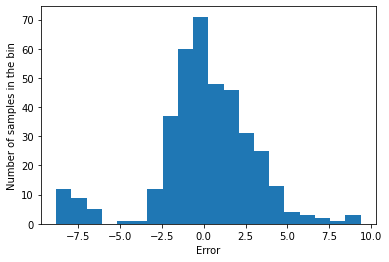

In [32]:
error_histogram(y_test_pred, y_test)